In [46]:
import numpy as np
import scipy as sp
import pandas as pd
from scipy import linalg as la
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter

In [37]:
def set_ticks(ax, xMaj, xMin, yMaj, yMin):
    ax.xaxis.set_major_locator(MultipleLocator(xMaj))
    ax.xaxis.set_minor_locator(AutoMinorLocator(xMin))
    ax.yaxis.set_major_locator(MultipleLocator(yMaj))
    ax.yaxis.set_minor_locator(AutoMinorLocator(yMin))
    ax.tick_params(which='major', width=1.0, length=10, direction="in", labelsize=12)
    ax.tick_params(which='minor', width=1.0, length=5, direction="in", labelsize=12)

1\. PCA on 3D dataset

* Generate a dataset simulating 3 features, each with N entries (N being ${\cal O}(1000)$). Each feature is made by random numbers generated according the normal distribution $N(\mu,\sigma)$ with mean $\mu_i$ and standard deviation $\sigma_i$, with $i=1, 2, 3$. Generate the 3 variables $x_{i}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues using the eigendecomposition of the covariance matrix
* Find the eigenvectors and eigenvalues using the SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained
* Redefine the data according to the new basis from the PCA
* Plot the data, in both the original and the new basis. The figure should have 2 rows (the original and the new basis) and 3 columns (the $[x_0, x_1]$, $[x_0, x_2]$ and $[x_1, x_2]$ projections) of scatter plots.

In [40]:
# generate dataset
N = 1000
x1 = np.random.normal(0, 1, N)
x2 = np.random.normal(0, 3, N) + x1
x3 = 2 * x1 + x2
data = np.array([x1, x2, x3])

# get covariance
cov = np.cov(data)
print("The covariance matrix is:\n", cov)

'''
    Eigendecomposition.
'''

# get eigenvalues and eigenvectors
egl, egv = la.eig(cov)

# sort them in order to match the latter SVD 
index = np.argsort(egl)[::-1]
egl = egl[index]
egv = egv[:, index]
egl_real = np.real_if_close(egl)
print("\nEIGENDECOMPOSITION:")
print("-Eigenvalues:\n", egl, "->", egl_real)
print("-Eigenvectors:\n", egv)

'''
    Perform the eigendecomposition using the SVD.
    The third eigenvalue is sensibly different. If one uses
    the np.allclose() method with a high precision of the 
    orderd o(1.e-20), the eingevalues are in fact different.
'''

# perform the Single Value Decomposition
U, S, V = la.svd(data)
egl_svd = S**2 / (N - 1)
egv_svd = U
print("\nEIGENDECOMPOSITION USING SVD:")
print("-Eigenvalues:\n", egl_svd)
print("-Eigenvectors:\n", egv_svd, "\n")

# check
check = np.allclose(egl, egl_svd, 1.e-2)
if check:
    print("The two procedures approximately yield the same eigenvalues.")
check_egv = np.allclose(egv, egv_svd, 1.e-2)
if check_egv:
    print("The two procedures approximately yield the same eigenvectors.")

The covariance matrix is:
 [[ 1.00490233  0.91072015  2.92052481]
 [ 0.91072015  9.32177678 11.14321707]
 [ 2.92052481 11.14321707 16.9842667 ]]

EIGENDECOMPOSITION:
-Eigenvalues:
 [ 2.52848992e+01+0.j  2.02604661e+00+0.j -1.08666049e-15+0.j] -> [ 2.52848992e+01  2.02604661e+00 -1.08666049e-15]
-Eigenvectors:
 [[-0.11903339  0.56494636 -0.81649658]
 [-0.57288176 -0.71073189 -0.40824829]
 [-0.81094854  0.41916082  0.40824829]]

EIGENDECOMPOSITION USING SVD:
-Eigenvalues:
 [2.53428171e+01 2.02642765e+00 2.24996630e-31]
-Eigenvectors:
 [[-0.11914735  0.56492233 -0.81649658]
 [-0.57273838 -0.71084744 -0.40824829]
 [-0.81103308  0.41899723  0.40824829]] 

The two procedures approximately yield the same eigenvalues.
The two procedures approximately yield the same eigenvectors.


In [41]:
'''
    Principal Component Analysis (PCA) via dimension
    reduction. We begin with p = 3 features, hence the
    dimensionality
'''

# get lambda matrix
Lambda = np.diag(egl_real)

# select components
components = (0, 1, 2, (0, 1), (0, 2), (1, 2))

# compute variability for each component
variability = (abs(Lambda[0,0])/Lambda.trace(), abs(Lambda[1,1])/Lambda.trace(),
               abs(Lambda[2,2])/Lambda.trace(), abs(Lambda[0,0]+Lambda[1,1])/Lambda.trace(),
               abs(Lambda[0,0]+Lambda[2,2])/Lambda.trace(), abs(Lambda[0,0]+Lambda[2,2])/Lambda.trace())

for i, j in zip(components, variability):
    var = j * 100
    print("By selecting the component", i, "we retain %.5f of the total variability." % var)
    if(var > 99):
        print("->The component", i, "retains at least 99% of the total variability.")

By selecting the component 0 we retain 92.58156 of the total variability.
By selecting the component 1 we retain 7.41844 of the total variability.
By selecting the component 2 we retain 0.00000 of the total variability.
By selecting the component (0, 1) we retain 100.00000 of the total variability.
->The component (0, 1) retains at least 99% of the total variability.
By selecting the component (0, 2) we retain 92.58156 of the total variability.
By selecting the component (1, 2) we retain 92.58156 of the total variability.


In [42]:
'''
    The features 0 and 1 are responsible for nearly 100% of 
    the variability. We only need 2 features to retain at 
    least 99% of the total variability.
    We can now rotate the dataset.
'''

# rotate dataset
rotated_data = np.dot(egv.T, data)     
#rotated_dataset

# reduce dataset
reduced_data = np.delete(rotated_data, np.argmin(egl_real), 0) 
#reduced_dataset

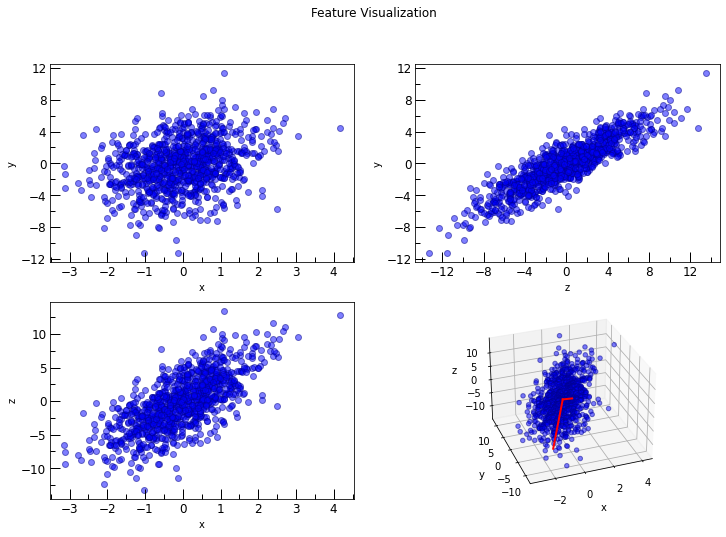

In [50]:
'''
    Visualize the features.
'''

# plot layout
fig = plt.figure(figsize = (12,8))
fig.suptitle("Feature Visualization")

# 0-1 scatter plot
ax1 = fig.add_subplot(2, 2, 1)
set_ticks(ax1, 1, 2, 4, 2)
ax1.scatter(data[0], data[1], marker='o', color='blue', edgecolor='darkblue', alpha=0.5)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
    
# 1-2 scatter plot
ax2 = fig.add_subplot(2, 2, 2)
set_ticks(ax2, 4, 2, 4, 2)
ax2.scatter(data[2], data[1], marker='o', color='blue', edgecolor='darkblue', alpha=0.5)
ax2.set_xlabel("z")
ax2.set_ylabel("y")

# 0-1 scatter plot
ax3 = fig.add_subplot(2, 2, 3)
set_ticks(ax3, 1, 2, 5, 2)
ax3.scatter(data[0], data[2], marker='o', color='blue', edgecolor='darkblue', alpha=0.5)
ax3.set_xlabel("x")
ax3.set_ylabel("z")

# 3D visualization
ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.scatter(data[0], data[1], data[2], marker='o', color='blue', edgecolor='darkblue', alpha=0.5)

for l, v in zip(egl_real, egv.T):
    ax4.plot([0, .5*l*v[0]], [0, .5*l*v[1]], [0, .5*l*v[2]], 'r-', lw=2, zorder=10)
    
ax4.view_init(elev = 30, azim = 250)
ax4.set_xlabel("x")
ax4.set_ylabel("y")
ax4.set_zlabel("z")

plt.show()

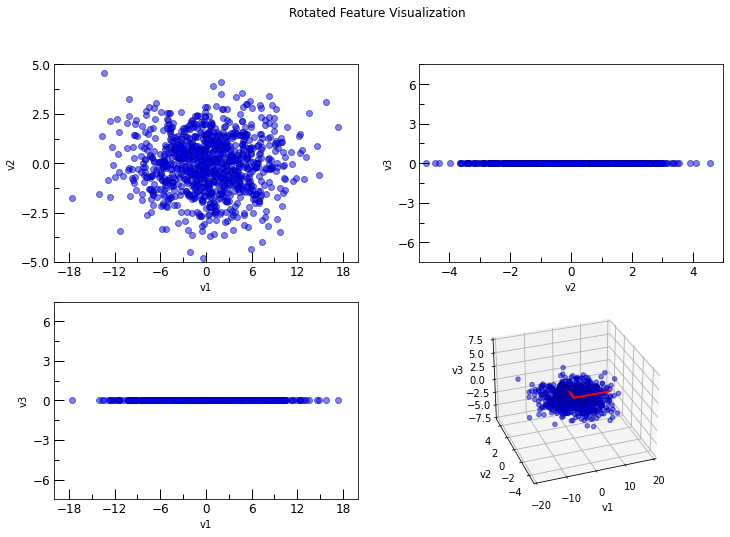

In [51]:
'''
    Visualize the rotated features.
'''

# plot layout
fig = plt.figure(figsize = (12,8))
fig.suptitle("Rotated Feature Visualization")

# limits
lim_v1 = (-20, 20)
lim_v2 = (-5, 5)
lim_v3 = (-7.5, 7.5)

# 0-1 scatter plot
ax1 = fig.add_subplot(2, 2, 1)
set_ticks(ax1, 6, 2, 2.5, 2)
ax1.scatter(rotated_data[0], rotated_data[1], marker='o', color='blue', edgecolor='darkblue', alpha=0.5)
ax1.set_xlabel("v1")
ax1.set_ylabel("v2")
ax1.set_xlim(lim_v1)
ax1.set_ylim(lim_v2)
    
# 1-2 scatter plot
ax2 = fig.add_subplot(2, 2, 2)
set_ticks(ax2, 2, 2, 3, 2)
ax2.scatter(rotated_data[1], rotated_data[2], marker='o', color='blue', edgecolor='darkblue', alpha=0.5)
ax2.set_xlabel("v2")
ax2.set_ylabel("v3")
ax2.set_xlim(lim_v2)
ax2.set_ylim(lim_v3)

# 0-1 scatter plot
ax3 = fig.add_subplot(2, 2, 3)
set_ticks(ax3, 6, 2, 3, 2)
ax3.scatter(rotated_data[0], rotated_data[2], marker='o', color='blue', edgecolor='darkblue', alpha=0.5)
ax3.set_xlabel("v1")
ax3.set_ylabel("v3")
ax3.set_xlim(lim_v1)
ax3.set_ylim(lim_v3)

# 3D visualization
ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.scatter(rotated_data[0], rotated_data[1], rotated_data[2], marker='o', color='blue', edgecolor='darkblue', alpha=0.5)

for l, v in zip(egl_real, np.diag([1]*3)):
    ax4.plot([0, .5*l*v[0]], [0, .5*l*v[1]], [0, .5*l*v[2]], 'r-', lw=2, zorder=10)
    
ax4.view_init(elev = 30, azim = 250)
ax4.set_xlabel("v1")
ax4.set_ylabel("v2")
ax4.set_zlabel("v3")
ax4.set_xlim(lim_v1)
ax4.set_ylim(lim_v2)
ax4.set_zlim(lim_v3)

plt.show()

2\. PCA on a nD dataset

* Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normally distributed, with a standard deviation much smaller (e.g. a factor 20) than those used to generate the $x_1$ and $x_2$. Repeat the PCA procedure and compare the results with what you have obtained before.

In [45]:
'''
    It is possible to see that we found the same
    principal components as in the previous exercise.
    The additional random noise feature has a negligible
    variablity.
'''

# generate noise
noise = []
for i in range(10):
    noise.append(np.random.normal(0, 1/50, N))

# add noise to original dataset
data_n = np.concatenate((data, np.array(noise)))

# covariance matrix
cov_n = np.cov(data_n)

# eigendecomposition
egl_n, egv_n = la.eig(cov_n)

# PCA
Lambda_n = np.diag(np.real_if_close(egl_n))
#print(np.real_if_close(egl_n) / np.trace(Lambda_n))

# results
var = abs(Lambda_n[0,0] + Lambda_n[1,1]) / Lambda_n.trace()
print("Obtained k = 2 and selecting components (0, 1) we retain", var*100,
      "of the total variability.")

Obtained k = 2 and selecting components (0, 1) we retain 99.98560711141278 of the total variability.


3\. **Optional**: PCA on the MAGIC dataset

Perform a PCA on the magic04.data dataset.

In [13]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P data/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P data/ 

In [35]:
# get data
d = pd.read_csv("data/magic04.data")

# set column names
labels = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym",
          "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"]
d.columns = labels

# print pd dataset
#d

In [25]:
# extract useful array
d = d[d["class"]=="g"]
d = d.drop(["class"], axis=1)

data = d.to_numpy()
data = data.reshape((data.shape[1], data.shape[0]))

In [33]:
'''
    Perform the PCA.
'''

# eigendecomposition
cov = np.cov(data[:,:1000])
egl, egv = la.eig(cov)

# PCA
Lambda = np.diag(np.real_if_close(egl))
egl = -np.sort(-np.real_if_close(egl))

PCA = egl / np.trace(Lambda)
#print(pca)

# select components
threshold = 99
variability = 0
for k in range(1, len(PCA)+1):
    variability = PCA[:k].sum() * 100
    if variability > threshold :
        print("PCA results: k =", k, " with retained variability of", variability)

PCA results: k = 10  with retained variability of 100.0


In [34]:
# with a lower threshold
threshold = 90
variability = 0
for k in range(1, len(PCA)+1):
    variability = PCA[:k].sum() * 100
    if variability > threshold :
        print("PCA results: k =", k, " with retained variability of", variability)

PCA results: k = 8  with retained variability of 91.23170293841733
PCA results: k = 9  with retained variability of 97.80970951992987
PCA results: k = 10  with retained variability of 100.0
